In [1]:
### Change Point Model ###
from change_detection import ChangePointDetector
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import sys 
sys.path.append('../../../')
from main import Manager 
m = Manager('../../../')
from bin.plots.volume_oi_chart import price_volume_oi_chart
from bin.utils.tools import pretty_print

2025-05-15 15:58:55,266 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-05-15 15:58:55,266 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-05-15 15:58:55,270 - INFO - PriceDB Initialized successfully at 2025-05-15 15:58:55.270219
2025-05-15 15:58:55,270 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-05-15 15:58:55.270219
2025-05-15 15:58:55,270 - INFO - Established 3 database connections
2025-05-15 15:58:55,270 - bin.price.db_connect - INFO - Established 3 database connections
2025-05-15 15:58:55,356 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


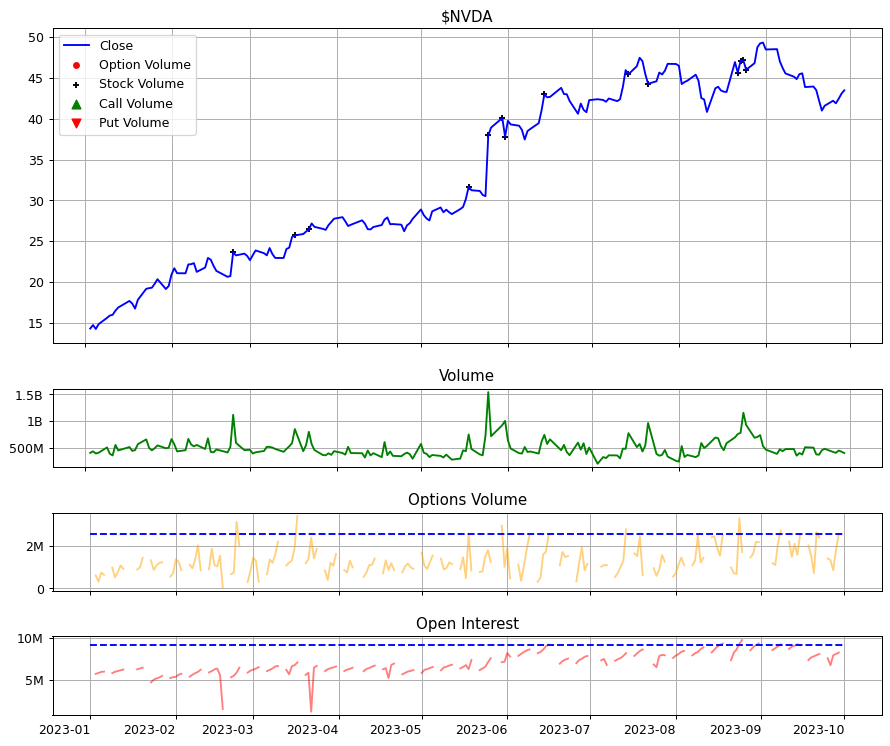

In [3]:
def get_aligned(stock):
    price_df = m.Pricedb.ohlc(stock)
    price_df =price_df.copy().sort_index()
    d = m.Optionsdb.get_daily_option_stats(stock).sort_index()
    d = d.resample('1D').sum()
    price_df = price_df.loc[d.index[0]:]
    d = d.replace(0, np.nan)
    return price_df, d

def show_volume_oi(stock, start_date = None, end_date = None):
    pdf, odf = get_aligned(stock)
    pdf.columns = [x.lower() for x in pdf.columns]
    fig, ax = plt.subplots(4, 1, height_ratios=[2, 0.5, 0.5, 0.5], figsize = (10, 10), dpi = 90)
    price_volume_oi_chart(odf, pdf, fig, ax, stock = stock, start_date=start_date, end_date=end_date)
    fig.show()
    return pdf, odf

_, _ = show_volume_oi('nvda', '2023-01-01', '2023-10-01')

: 

: 

: 

In [4]:
from trend_results import TResults
tr = TResults(
    connections = '../../../',
    lookback_days= 90,
    window_size = 200, 
    period = 30
    
    )


2025-05-15 15:59:03,724 - bin.options.optgd.db_connect - INFO - Options DB Initialized


2025-05-15 15:59:03,725 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-05-15 15:59:03,742 - INFO - PriceDB Initialized successfully at 2025-05-15 15:59:03.741893
2025-05-15 15:59:03,742 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-05-15 15:59:03.741893
2025-05-15 15:59:03,781 - INFO - Established 3 database connections
2025-05-15 15:59:03,781 - bin.price.db_connect - INFO - Established 3 database connections
2025-05-15 15:59:03,839 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


In [5]:
results = tr.analyze_stocks()

Processing nvo: 100%|██████████| 134/134 [00:39<00:00,  3.42it/s, Success=1]


In [6]:
# Convert to DataFrame
data = []
for i in results:
    for result in i:
        data.append({
            'stock': result.stock,
            'metric': result.name,
            'trend_direction': result.trend_direction,
            'seasonality': result.seasonality,
            'slope': result.slope,
            'change_point': result.change_point
        })
df = pd.DataFrame(data)

# Flag slope discrepancies (where trend direction and slope sign don't match)
df['slope_discrepancy'] = ((df['trend_direction'] == 'up') & (df['slope'] < 0)) | ((df['trend_direction'] == 'down') & (df['slope'] > 0))
print("DataFrame with Slope Discrepancies Flagged:")
df[df.slope_discrepancy == True]

DataFrame with Slope Discrepancies Flagged:


,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
0,gme,close_prices,up,normal,-0.000816,1.0,True
5,gme,call_oi,up,normal,-0.001136,0.0,True
12,amzn,oi,up,normal,-0.006335,0.0,True
14,amzn,call_oi,up,normal,-0.007320,0.0,True
15,amzn,put_oi,up,normal,-0.005349,0.0,True
...,...,...,...,...,...,...,...
1154,tem,options_volume,up,normal,-0.009200,1.0,True
1159,tem,call_volume,up,normal,-0.006608,1.0,True
1160,tem,put_volume,up,normal,-0.020490,1.0,True
1163,btu,options_volume,down,normal,0.005441,0.0,True


In [7]:
df.metric.unique()

array(['close_prices', 'stock_volume', 'options_volume', 'oi', 'atm_iv',
       'call_oi', 'put_oi', 'call_volume', 'put_volume'], dtype=object)

In [8]:
increasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'up')].stock.tolist()
increasing_call_oi = df[(df.metric == 'call_oi') & (df.trend_direction == 'up')].stock.tolist()
decreasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'down')].stock.tolist()

increasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'up')].stock.tolist()
increasing_call_volume = df[(df.metric == 'call_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price = df[(df.metric == 'close_prices') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price = df[(df.metric == 'close_prices') & (df.trend_direction == 'down')].stock.tolist()


def print_10_items_per_line(title, lst):
    print(title)
    print("=====================================")
    for i in range(0, len(lst), 10):
        print(", ".join(lst[i:i+10]))


print_10_items_per_line("Decreasing Options Volume:", decreasing_options_volume)
print_10_items_per_line("Decreasing Price Volume:", decreasing_price_volume)

Decreasing Options Volume:
gme, amzn, aapl, pfe, pep, ntr, dkng, mdb, wmt, cvx
fcel, vale, mo, intc, mu, hd, rrc, lc, vuzi, bkkt
lmt, wfc, crwd, mrk, baba, tsla, sol, mos, qs, tgt
meta, abbv, ccj, f, pypl, amd, amc, xom, clsk, asan
hsbc, kr, wba, ba, cmre, ge, intu, snap, nvda, ctva
aa, csco, ko, ctra, snow, li, run, lulu, oxy, c
abnb, x, mara, clx, jpm, k, sony, hood, cag, ual
pgr, aig, avgo, sofi, mpw, amat, open, panw, tdoc, djt
dell, dltr, adbe, orcl, u, tost, pct, oklo, btu
Decreasing Price Volume:


In [9]:

print_10_items_per_line("Increasing OI:", list(set(increasing_oi + increasing_price)))
print_10_items_per_line("Increasing Call OI:", list(set(increasing_call_oi + increasing_price)))

Increasing OI:
ge, mmm, cvs, x, cava, aapl, amat, hd, pct, xom
clx, nvda, enph, mdb, mos, intu, snow, uber, lmt, btu
tsla, cvx, oklo, ba, jpm, goog, pltr, dkng, meta, gme
snap, djt, dbx, ko, ttd, sono, wmt, pfe, tgt, gsl
dash, afrm, hood, msft, spot, sol, pypl, ntr, hims, wfc
rtx, u, oxy, dell, v, eog, aa, mrk, hsbc, mo
crwd, pep, aal, qcom, sbux, arm, dltr, ups, rkt, ual
nflx, f, dis, afl, pgr, ebay, roku, ccj, kr, clsk
k, c, run, fang, amzn, rblx
Increasing Call OI:
ge, mmm, cvs, x, cava, aapl, amat, pct, xom, clx
enph, mdb, mos, intu, snow, uber, lmt, btu, tsla, cvx
oklo, abbv, ba, jpm, goog, pltr, tost, meta, gme, snap
djt, dbx, ko, sono, wmt, orcl, tgt, dash, afrm, hood
msft, spot, sol, pypl, ntr, amd, hims, wfc, rtx, u
oxy, dell, v, aa, mrk, hsbc, mo, crwd, pep, aal
qcom, sbux, arm, dltr, ups, rkt, nflx, f, sofi, dis
afl, panw, pgr, ebay, ccj, kr, clsk, k, tsn, c
run, fang, amzn, rblx


In [12]:
b = set(increasing_options_volume) & set(increasing_price) 
b = set(increasing_options_volume) & set(increasing_price) & set(increasing_call_volume) & set(increasing_call_oi)
print(b)

{'msft', 'cava', 'rblx', 'uber', 'spot'}


,total_vol,call_vol_chng,put_vol_chng,total_oi,call_oi,call_oi_chng,put_oi,put_oi_chng
date,,,,,,,,
2025-05-11,nan,nan,nan,nan,nan,nan,nan,nan
2025-05-12,"191,860.00","-122,774.00","-56,848.00","995,136.00","621,684.00","-9,880.00","373,452.00","-48,146.00"
2025-05-13,"146,305.00","-69,083.00","-38,724.00","1,025,618.00","637,614.00","15,930.00","388,004.00","14,552.00"
2025-05-14,"169,762.00","1,052.00",-904.00,"1,061,268.00","662,324.00","24,710.00","398,944.00","10,940.00"
2025-05-15,"58,246.00","-25,073.00","-2,461.00","540,861.00","336,192.00","5,030.00","204,669.00","5,197.00"


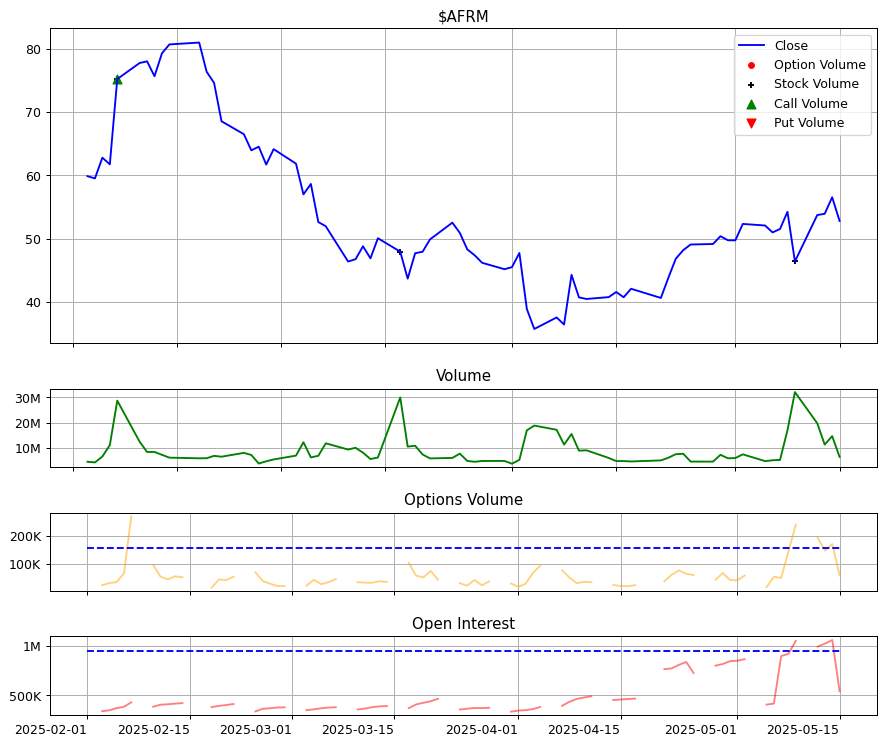

In [11]:
_, odf = show_volume_oi('afrm',start_date = "2025-02-01")

pretty_print(odf[['total_vol', 'call_vol_chng', 'put_vol_chng', 'total_oi', 'call_oi','call_oi_chng', 'put_oi','put_oi_chng']].tail())

In [13]:
change_df = df[df.change_point == 1]
call_volume_change = list(change_df[change_df.metric.isin(['call_volume'])].stock.unique())
put_volume_change = list(change_df[change_df.metric.isin(['put_volume'])].stock.unique())
print_10_items_per_line('Call Change Points',call_volume_change)

Call Change Points
gme, uber, pltr, wmt, intc, mu, rrc, baba, tsla, msft
rkt, amd, coin, ba, nvda, cvs, run, hood, avgo, smci
hims, rddt, dltr, pct, oklo, tem, btu


,total_vol,total_prem,total_oi,call_vol,put_vol,call_oi,put_oi,call_iv,put_iv,atm_iv,...,call_oi_chng,put_oi_chng,call_iv_chng,put_iv_chng,atm_iv_chng,otm_iv_chng,call_vol_pct_chng,put_vol_pct_chng,call_oi_pct_chng,put_oi_pct_chng
date,,,,,,,,,,,,,,,,,,,,,
2025-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-12,393059.0,3.057829e+07,1419268.0,241078.0,151981.0,728380.0,690888.0,2.038795,2.184185,2.158153,...,-79918.0,-181880.0,0.301551,0.267640,0.362817,0.009391,-0.046842,0.046842,0.064767,-0.064767
2025-05-13,558814.0,3.851387e+07,1495586.0,306596.0,252218.0,760538.0,735048.0,2.291952,2.314761,2.444424,...,32158.0,44160.0,0.335072,0.097677,0.428541,0.896612,-0.132957,0.132957,-0.009373,0.009373
2025-05-14,238862.0,3.850276e+07,1594736.0,122254.0,116608.0,785580.0,809156.0,2.511663,2.088062,2.568824,...,25042.0,74108.0,0.233517,-0.259815,0.120365,0.583033,-0.062635,0.062635,-0.031827,0.031827
2025-05-15,229682.0,1.752551e+07,832764.0,117248.0,112434.0,395207.0,437557.0,1.047511,1.156742,1.130022,...,2417.0,32979.0,-0.130138,0.064248,-0.093096,-0.396153,0.013308,-0.013308,-0.018036,0.018036


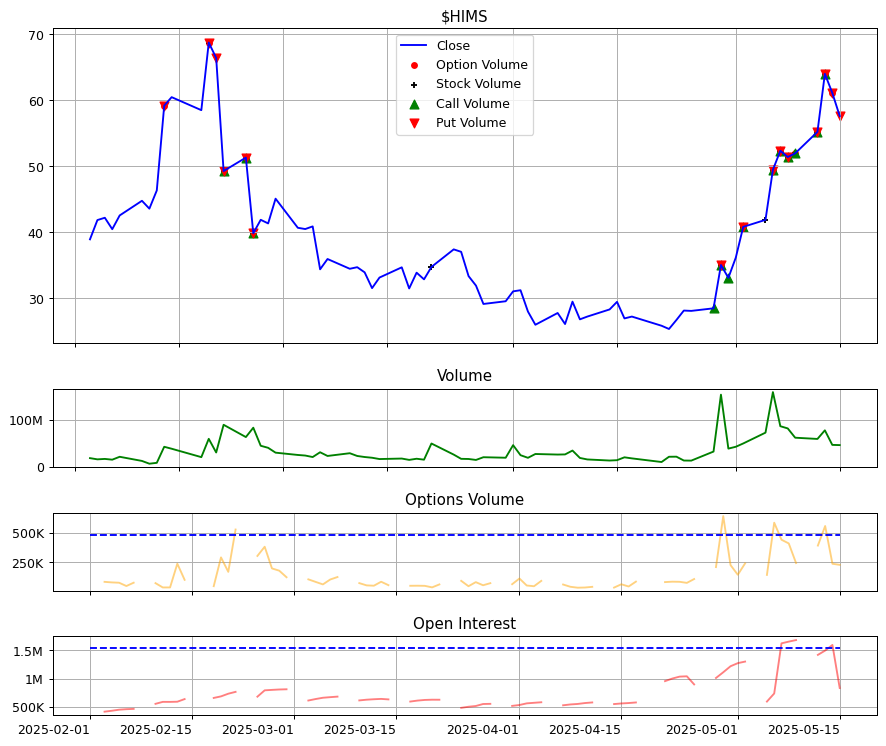

In [16]:
_, b = show_volume_oi('hims', start_date = "2025-02-01")
b.tail()

In [17]:
df

,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
0,gme,close_prices,up,normal,-0.000816,1.0,True
1,gme,stock_volume,up,normal,0.020711,0.0,False
2,gme,options_volume,down,normal,-0.000415,1.0,False
3,gme,oi,down,normal,-0.001282,0.0,False
4,gme,atm_iv,up,normal,0.000992,1.0,False
...,...,...,...,...,...,...,...
1165,btu,atm_iv,up,normal,0.078907,1.0,False
1166,btu,call_oi,up,normal,0.012122,1.0,False
1167,btu,put_oi,up,normal,0.011901,1.0,False
1168,btu,call_volume,up,normal,0.011024,1.0,False
